In [1]:
#IMPORT NECESSARY PACKAGES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import pymysql.cursors
import datetime
import matplotlib.gridspec as grd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from time import mktime

In [2]:
#Ask the user for the date range between which data will be pulled from SQL
def get_date_range():
    date1=input("Enter Start Date YYYY-mm-DD: ")
    date2=input("Enter End Date YYYY-mm-DD: ")
    return date1,date2

In [3]:
def sql_connect():
    #Connect to SQL database with username and pw
    mydb = pymysql.connect(
        host='155.98.6.253',
        user='EddyFlux',
        passwd = 'UvTrhM_yFo71X2',
        database = 'CO2_Eddy'
        )
    
    #Set up cursor (allows navigation through SQL syntax)
    mycursor = mydb.cursor()
    
    return mycursor

In [4]:
def get_LI_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" LI_8100 Data         # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    
    mycursor = sql_connect()
    mycursor.execute("SELECT Local_DT, EPOCH_TIME, Cdry\
                        FROM {}\
                        WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                        order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL statement
    data = mycursor.fetchall() #fetch the data
    LI_vent = pd.DataFrame(list(data)) #convert imported data to dataframe
    LI_vent.columns = ['Local_DT','EPOCH_TIME','CO2'] #name columns
    cols = LI_vent.columns.drop('Local_DT') #get all column names beside date column
    LI_vent[cols]=LI_vent[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return LI_vent

In [5]:
def get_multiplexer_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" Multiplexer Data     # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    #Connect to SQL
    mycursor = sql_connect()   
    mycursor.execute("SELECT *\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL query
    data = mycursor.fetchall() #fetch the data
    Multiplexer = pd.DataFrame(list(data)) #convert imported data into a dataframe
    Multiplexer.columns = ['Local_DT','EPOCH_TIME','CO2_1','CO2_2','CO2_3','Rotations','Wind_Velocity','Wind_Direction','Temp','Location'] #name columns
    cols = Multiplexer.columns.drop('Local_DT') #get all column names but date column
    Multiplexer[cols]=Multiplexer[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Multiplexer

In [6]:
def get_vent_anem_temp_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" Vent_Anem_Temp Data  # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    
    #Connect to SQL
    mycursor = sql_connect()
    mycursor.execute("SELECT *\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL query
    data = mycursor.fetchall() #fetch the data
    Vent_Anem_Temp = pd.DataFrame(list(data)) #convert imported data to a dataframe
    Vent_Anem_Temp.columns = ['Local_DT','EPOCH_TIME','Rotations','Velocity','Temp_1','Temp_2'] #name columns
    cols = Vent_Anem_Temp.columns.drop('Local_DT') #get all column names but date
    Vent_Anem_Temp[cols]=Vent_Anem_Temp[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Vent_Anem_Temp
clip = get_vent_anem_temp_data('Aug2019_Vent_Anem_Temp','2019-08-15','2019-09-2')

In [7]:
def get_picarro_data(tablename,date1,date2):
    ###################################################################
    # Function to get exclusively "Spike Necessary" Picarro Data from #
    # SQL. Input the SQL Tablename, and date range between which data #
    # will be fetched. For one day's worth of data, enter the same    #
    # Date.                                                           #
    ###################################################################
    
    #Connect to SQL
    mycursor = sql_connect()
    mycursor.execute("SELECT Local_DT, EPOCH_TIME, CO2_dry, ANEMOMETER_UY\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL statement
    data = mycursor.fetchall() #fetch the data
    Picarro = pd.DataFrame(list(data)) #convert data to a dataframe
    Picarro.columns = ['Local_DT','EPOCH_TIME','CO2','ANEM_Y'] #name columns
    cols = Picarro.columns.drop('Local_DT') #get all column names but date
    Picarro[cols]=Picarro[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Picarro

In [8]:
#Script pulls in all of the necessary data in the date range input into the function
#Inputs: The names of each SQL table
#        date1 - start date for range of data to pull
#        date2 - end date for range of data to pull
def get_sql_data(LI_vent_sql_tablename,Multiplexer_sql_tablename,\
                 Vent_Anem_Temp_sql_tablename,Picarro_sql_tablename,date1,date2):
    
    ######################################################################
    # Function to get exclusively "Spike Necessary" Vent_Anem_Temp Data  # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################

    #Import source (LI_8100_Vent) data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        LI_vent = get_LI_data(LI_vent_sql_tablename,date1,date2)
    except ValueError:
        LI_vent = pd.DataFrame() #set empty dataframe
        pass
    
    
    #Import Multiplexer data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Multiplexer = get_multiplexer_data(Multiplexer_sql_tablename,date1,date2)
    except ValueError:
        Multiplexer = pd.DataFrame() #make empty dataframe
        pass
    
    #Import Vent_Anem_Temp data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Vent_Anem_Temp = get_vent_anem_temp_data(Vent_Anem_Temp_sql_tablename,date1,date2)
    except ValueError:
        Vent_Anem_Temp = pd.DataFrame() #make empty dataframe
        pass

    
    #Import Picarro data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Picarro = get_picarro_data(Picarro_sql_tablename,date1,date2)
    except ValueError:
        Picarro = pd.DataFrame() #make empty dataframe
        pass
    
    return LI_vent, Multiplexer, Vent_Anem_Temp, Picarro #return all of the fetched dataframes

In [9]:
#Plot a simple graph with local_dt on the x axis, and an input (y_ax) on the y axis
def simple_plot(df,timecol,y_ax):
    fig,ax = plt.subplots() #make the fig,ax
    ax.yaxis.grid(which="major") #plot horizontal gridlines
    ax.plot(df[timecol],df[y_ax]) #plot
    plt.gcf().autofmt_xdate() #get a nice date format for the x axis
    fig.tight_layout()
    plt.show()

In [10]:
#Make a figure of multiple plots plotted above one another. X axes have the same values
def plot_vertical_stack(x_ax,df):
    if 'CO2_1' in df: #if there is CO2_1, we are in multiplexer data, and want three plots, one for each CO2 value of muliplexer
        fig = plt.figure(figsize=(15,5)) #set fig, ax with a figsize
        gs = grd.GridSpec(3,1) # three plots
        ax = fig.add_subplot(gs[0]) # add first subplot
        ax.plot(df[x_ax],df['CO2_1'],color='blue') #plot first subplot
        ax = fig.add_subplot(gs[1],sharex=ax) #make second subplot with same xaxis as first
        ax.plot(df[x_ax],df['CO2_2'],color='red')
        ax = fig.add_subplot(gs[2],sharex=ax)
        ax.plot(df[x_ax],df['CO2_3'],color='black')
        plt.gcf().autofmt_xdate() #format the date
        fig.tight_layout()
        plt.show()
    else :
        fig = plt.figure(figsize=(10,5))
        gs = grd.GridSpec(2,1)
        ax = fig.add_subplot(gs[0])
        ax.plot(df[x_ax],df['CO2'],color='blue')
        ax = fig.add_subplot(gs[1],sharex=ax)
        ax.plot(df[x_ax],df['ANEM_Y'],color='red')
        plt.gcf().autofmt_xdate()
        fig.tight_layout()
        plt.show()

In [11]:
#This function allows the user to specify the range over which to plot picarro data
def plot_refinement_picarro(x_ax,df):
    #plot_vertical_stack(df) #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False    
        df1=df
    while cont_ref: #continue asking user to refine until command is given
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df[x_ax]>=DT1)&(df[x_ax]<=DT2)] #clip the data to the range given

        plot_vertical_stack(df1) #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
    
    return df1 #return the df with the user chosen range

In [12]:
#This function allows the user to specify the range over which to plot LI data
def plot_refinement_LI(timecol,df):
    fig = plt.figure()
    plt.plot(df[timecol],df['CO2'])  #plot the data
    plt.gcf().autofmt_xdate()
    fig.tight_layout()
    plt.show()
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False    
        df1=df
    while cont_ref:       #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ")  #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ")   #get end of range

        df1 = df.loc[(df[timecol]>=DT1)&(df[timecol]<=DT2)] #clip the data to the range given

        plt.plot(df1[timecol],df1['CO2']) #plot over that range
        plt.gcf().autofmt_xdate()
        fig.tight_layout()
        plt.show()
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [13]:
#This function allows the user to specify the range over which to plot Multiplexer data
def plot_refinement_multiplexer(x_ax,df):
    plot_vertical_stack(x_ax,df) #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False
        df1=df
        
    while cont_ref:          #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df[x_ax]>=DT1)&(df[x_ax]<=DT2)] #clip the data to the range given

        plot_vertical_stack(x_ax,df1) #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [14]:
#This function allows the user to specify the range over which to plot Multiplexer data
def plot_refinement_vent_anem_temp(df):
    simple_plot(df,'Velocity') #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False
        df1=df
        
    while cont_ref:          #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        simple_plot(df1,'Velocity') #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [15]:
#This function refines all dataframes to user specified ranges
def get_tighter_ranges(LI_vent, LI_remote, Multiplexer, Picarro):
    Picarro = plot_refinement_picarro(Picarro) #refine picarro range
    LI_vent = plot_refinement_LI(LI_vent) #refine LI_vent range
    Multiplexer = plot_refinement_multiplexer(Multiplexer) #refine Multiplexer range
    return LI_vent, LI_remote, Multiplexer, Picarro         #return the refined range dataframes for each dataframe

In [16]:
def fill_multiplexer_gaps(df):
    st = df['EPOCH_TIME'].min()
    end =  df['EPOCH_TIME'].max()

    x = df.set_index('EPOCH_TIME').reindex(range(st,end,1)).interpolate().rename_axis('EPOCH_TIME').reset_index()

    x['Local_DT'] = pd.to_datetime(x['EPOCH_TIME'],unit='s') - pd.Timedelta('06:00:00')

    return x

In [17]:
def create_lag_df(actual_spike_df):
    cols = actual_spike_df.columns.drop(['Actual_DT','Actual_ET'])
    lags = pd.DataFrame()
    lags['Actual_DT'] = actual_spike_df['Actual_DT']
    lags['Actual_ET'] = actual_spike_df['Actual_ET']
    for col in cols:
        lags[col] = actual_spike_df['Actual_ET'] - actual_spike_df[col]

    return lags

In [18]:
date1,date2 = get_date_range()
LI_vent, Multiplexer, Vent_Anem_Temp, Picarro, \
= get_sql_data("Aug2019_LI_8100_Vent",\
              "Aug2019_Multiplexer","Aug2019_Vent_Anem_Temp",\
              "Aug2019_Picarro",date1,date2)
#Multiplexer = get_multiplexer_data("Aug2019_Multiplexer",date1,date2)

Enter Start Date YYYY-mm-DD:  2019-10-01
Enter End Date YYYY-mm-DD:  2019-10-03


In [20]:
def get_lag_groups(actual_spike_df,column):
    spike_df = actual_spike_df[['Actual_DT','Actual_ET',column]].dropna()
    spike_df['lags'] = spike_df.apply(lambda row: row['Actual_ET']-row[column],axis=1)
    spike_df['diff'] = spike_df['Actual_ET'] - spike_df['Actual_ET'].shift(1)
    spike_df.reset_index(drop=True,inplace=True)
    
    grp = int(0)
    df_list = {}
    st_ix = 0 
    end_ix = 0
    for i in range(1,len(spike_df)):
        if spike_df.loc[i,'diff'] < 1000:
            end_ix += 1
        else:
            df_list[grp] = pd.DataFrame(spike_df.loc[st_ix:end_ix])
            grp+=1
            end_ix += 1
            st_ix = end_ix
    df_list[grp] = pd.DataFrame(spike_df.loc[st_ix:end_ix])

    ETs = []
    ave_lags = []
    for i in range(0,len(df_list)):
        ETs.append((df_list[i][column].iloc[0]+df_list[i][column].iloc[-1])/2)
        ave_lags.append(np.mean(df_list[i]['lags']))

    final_lags = pd.DataFrame({'mid_ET':ETs,'ave_lag':ave_lags})

    for i in range(0,len(final_lags)-1):
        final_lags.loc[i,'slope']= (final_lags.loc[i,'ave_lag']-final_lags.loc[i+1,'ave_lag'])/(final_lags.loc[i,'mid_ET']-final_lags.loc[i+1,'mid_ET'])
        
    return final_lags

In [21]:
def df_correction_lag_slope(final_lags,df_to_correct):

    def row_correction(row,final_lags_df,grp):
        return row+final_lags_df['ave_lag'][grp]+(row-final_lags_df['mid_ET'][grp])*final_lags_df['slope'][grp]

    df_corr_list = {}
    df_corr_list[0] = df_to_correct.where((df_to_correct['EPOCH_TIME'] < final_lags.loc[1,'mid_ET'])).dropna()
    df_corr_list[0]['Corrected_ET'] = df_corr_list[0]['EPOCH_TIME'].apply(row_correction,args=(final_lags,0))
    df_corr_list[0]['Corrected_DT'] = df_corr_list[0]['Corrected_ET'].apply(lambda x: datetime.fromtimestamp(x))

    for i in range(1,len(final_lags)-1):
        df_corr_list[i] = df_to_correct.where((df_to_correct['EPOCH_TIME'] >= final_lags.loc[i,'mid_ET']) & (df_to_correct['EPOCH_TIME'] <= final_lags.loc[i+1,'mid_ET'])).dropna()
        df_corr_list[i]['Corrected_ET'] = df_corr_list[i]['EPOCH_TIME'].apply(row_correction,args=(final_lags,i))
        df_corr_list[i]['Corrected_DT'] = df_corr_list[i]['Corrected_ET'].apply(lambda x: datetime.fromtimestamp(x))

    corrected_df = pd.concat(df_corr_list)
    
    return corrected_df

In [22]:
final_lags = get_lag_groups(pd.read_pickle('All_actualET.pkl'),'Multiplexer_CO2_1')
Multiplexer = df_correction_lag_slope(final_lags,Multiplexer)


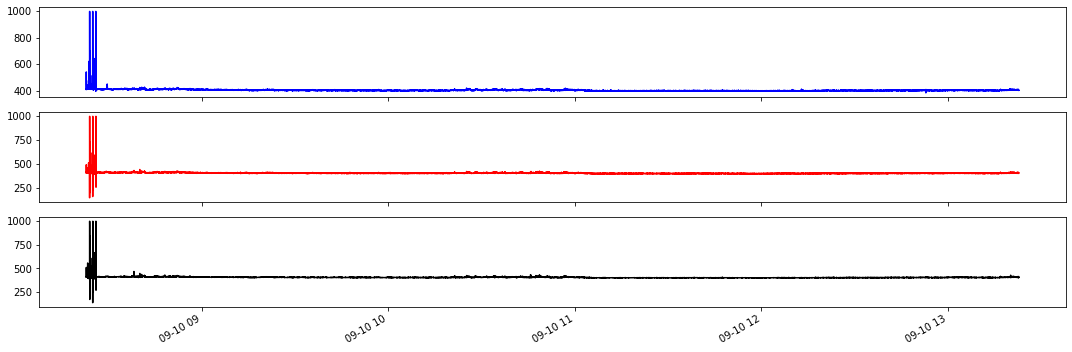

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-10 08:23:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-09-10 08:27:00


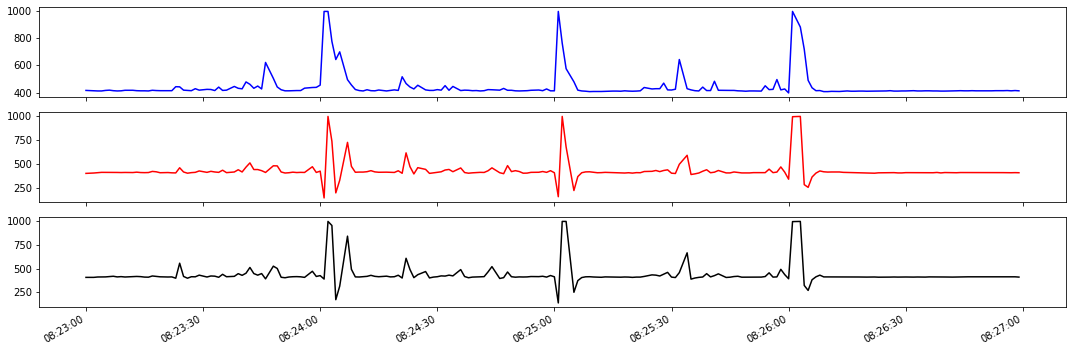

Is this an acceptable range?  y


In [23]:
clip = plot_refinement_multiplexer('Corrected_DT',Multiplexer)

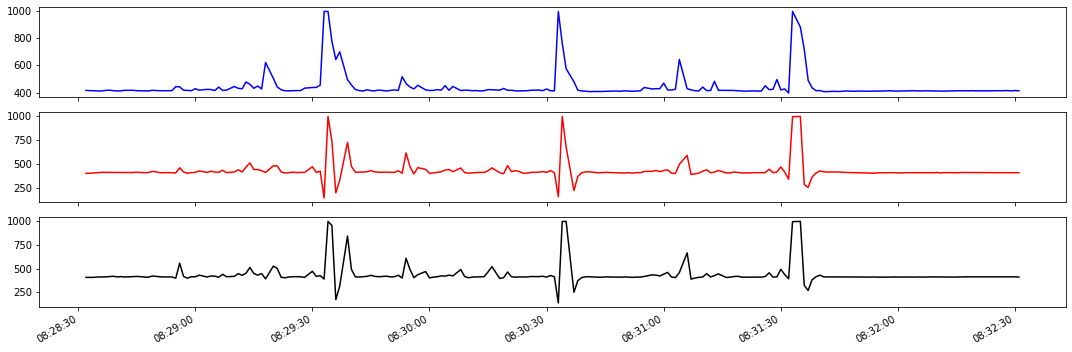

In [25]:
plot_vertical_stack('Local_DT',clip)

In [ ]:
np.where(Multiplexer.duplicated('Corrected_DT'))